# Homework 3 Arno Strouwen
## Part 1
Google colab would not allow any GPU instances since Saturday 26/03.
I thus made this homework locally on my (gaming) PC equipped with an Nvidia 3080.
I could not get exactly the same version of the packages to run locally, thus there are some API differences with the code from the book.
This notebook contains the answers to part 1, multi label classification on the VOC2012 dataset. There is a separate notebook for part 2.

In [62]:
from typing import List, Tuple
import os
import xml.etree.ElementTree as etree
import pydot

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

I will attempt classification with all classes. A brief literature review indicates that ResNet is a good architecture for this multi-label classification problem (Source: https://paperswithcode.com/sota/multi-label-classification-on-pascal-voc-2012). 

In [2]:
_VOC_LABELS = (
    "aeroplane","bicycle","bird","boat","bottle",
    "bus","car","cat","chair","cow",
    "diningtable","dog","horse","motorbike","person",
    "pottedplant","sheep","sofa","train","tvmonitor",
)
filter = _VOC_LABELS 

Let us first define some helper functions.

In [3]:
def index_to_name(i, filter):
  return(filter[i])

def name_to_index(n,filter):
  return filter.index(n)

def indices_to_names(y, filter):
  names=[]
  for i,v in enumerate(y):
    if v==1:
      names.append(index_to_name(i,filter))
  return names

def load_image(im_path,label,preprocess):
    img_raw = tf.io.read_file(im_path)
    img = tf.io.decode_image(img_raw, dtype=tf.dtypes.uint8,expand_animations = False)
    img = tf.image.resize(img,(image_size,image_size),preserve_aspect_ratio=False,antialias=True)
    if preprocess:
        img = tf.keras.applications.resnet50.preprocess_input(img)
    return img, label

def get_image_paths(base_dir, filter:List[str] =None):
  #returns list of paths to jpg files and xml annotations

  IMAGE_PATH = os.path.join(base_dir,'JPEGImages')
  ANNOTATION_PATH = os.path.join(base_dir,'Annotations')
  LISTS=os.path.join(base_dir,'ImageSets','Main')
  image_files_paths = []
  annotations_paths = []

  names=[]
  if filter==None:
    with open(os.path.join(LISTS,'trainval.txt' )) as f:
      for line in f:
        names.append(line[:-1])

  else:
    for target_class in filter:
      with open(os.path.join(LISTS,target_class+'_trainval.txt' )) as f:
        for line in f:
          tmp=line[:-1].split()
          if not (tmp[1] == '-1'):
            names.append(tmp[0])
        # remove duplicates
      tmp = []
      [tmp.append(x) for x in names if x not in tmp]
      names=tmp
    
  for name in names:
    image_files_paths.append(os.path.join(IMAGE_PATH,name+'.jpg'))
    annotations_paths.append(os.path.join(ANNOTATION_PATH, name+'.xml'))

  return image_files_paths, annotations_paths
def xml_to_labels(xml_paths, filter=None):
  # parse xml files and return binarised matrix indicating
  # pressense of 
  classes = filter if filter else _VOC_LABELS
  nr_classes = len(classes)
  labels=np.zeros(shape=[len(xml_paths),nr_classes])
  for i,path in enumerate(xml_paths):
    z=etree.parse(path)
    labels_found=[obj.find('name').text for obj in z.findall('./object')]
    for label in labels_found:
      if label in classes:
        index= name_to_index(label,classes)
        labels[i,index]=1
  return labels


Now let us load the images and labels.

In [4]:
base_dir = os.path.join("VOCdevkit","VOC2012")
image_files_paths, annotations_paths = get_image_paths(base_dir,filter)
labels = xml_to_labels(annotations_paths, filter)

We will use 80% of the data for training, 10% for hyper-parameter tuning and 10% for testing the perfomance of the final model.

In [5]:
X_train, X_rest, y_train, y_rest=train_test_split(image_files_paths, labels,
                                                  train_size=0.8, shuffle=True, random_state=2022)
X_val, X_test, y_val, y_test=train_test_split(X_rest, y_rest,
                                                  train_size=0.5, shuffle=True, random_state=2022)
print(f'train samples: {len(X_train)} \nval samples: {len(X_val)} \ntest samples: {len(X_test)}')

train samples: 9232 
val samples: 1154 
test samples: 1154


We downsample the images to 128 pixels both in height and width, and use a batch size of 32 images. This uses up all 10GB of GPU memory during training.
Similarly, ResNet101 is too large for my single GPU workstation.
ResNet requires the images to be preprocessed a certain way. But for plotting the images without prepocessing are needed.

In [6]:
image_size = 128
batch_size = 32
def create_data_set(X,Y,preprocess):
    ds=tf.data.Dataset.from_tensor_slices((X,Y))
    ds=ds.shuffle(buffer_size=5000)
    ds=ds.map(lambda x,y :load_image(x,y,preprocess),num_parallel_calls=tf.data.AUTOTUNE)
    ds=ds.cache()
    ds=ds.prefetch(tf.data.AUTOTUNE)
    ds=ds.batch(batch_size)
    return ds

In [7]:
ds_train_pp = create_data_set(X_train,y_train,True)
ds_val_pp = create_data_set(X_val,y_val,True)
ds_test_pp = create_data_set(X_test,y_test,True)
ds_test_no_pp = create_data_set(X_test,y_test,False)

We allow the pretrained model to be further fine-tuned on our data. We remove the final dense layers from the network, only keeping the convolutional layers, that should serve as automatic feature crafters. The ResNet50 architecture contains batch normalization and residual connections under the hood, advanced features required for this homework. Since I manually implemented these layers already in homework 2, I will not do so again for this homework. In the previous homework, I saw that data-augmentation had little value for fine-tuning large pretrained models, compared to its value when training from scratch, thus I omitted an augmentation layer.

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_15[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

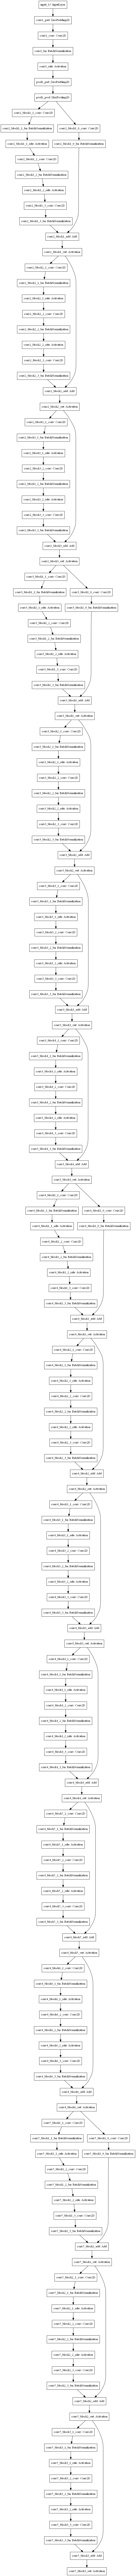

In [75]:
conv_base = tf.keras.applications.resnet.ResNet50(
    include_top=False,
    input_tensor=None,
    input_shape=(image_size, image_size, 3),
)
conv_base.trainable = True
conv_base.summary()
tf.keras.utils.plot_model(conv_base)

After the pre-trained convolutional layer, we add our own dense layers. For the output layer sigmoid activation functions are used. For a single image the output contains as many units as there are classes, each unit is a number between 0 and 1 and models if a label should be assigned to the image. If binary crossentropy is used as a loss, then this loss is evaluated per unit of the output layer. The loss then gradually decreases as more of the labels for a given image are classified correctly, i.e. not all the labels have to be correct for the loss to decrease. A similar explanation holds for validation metrics such as binary accuracy. I am not completely pleased with this approach. Most classes are not present in any given image since, thus a model that always outputs zero for every output unit, will have a low loss and high accuracy, 92.3% to be exact. Taking inspiration from part 2 of the homework, we will use dice loss instead of binary crossentropy. In part 2, we reason that dice loss works better for segmenting images that mostly consist of background. Similarly for multi-label classification most classes are absent from most images, and the optimization should not focus only on improving true negatives. This somewhat remedies the imbalance between zeros and ones in the output, but there is still imbalance between the different labels, i.e. in which layer of the output the ones mostly occur. If I had more time to experiment with the model structure, I would try to modify the dice loss in such a way that the different labels carry different weights. The output layer also does not enforce that at least a single label has to be present, but I see no straightforward way to achieve this.

In [9]:
1 - sum([sum(y) for y in y_train])/(len(y_train)*len(filter))

0.9231423310225303

In [13]:
def diceloss(y_true, y_pred):
  y_true = tf.cast(y_true, tf.float32)
  numerator = 2 * tf.reduce_sum(y_true * y_pred)
  denominator = tf.reduce_sum(y_true + y_pred)
  return 1 - numerator / denominator

An example of such an architecture:

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               8388864   
_________________________________________________________________
dense_1 (Dense)              (None, 20)                5140      
Total params: 31,981,716
Trainable params: 31,928,596
Non-trainable params: 53,120
_________________________________________________________________


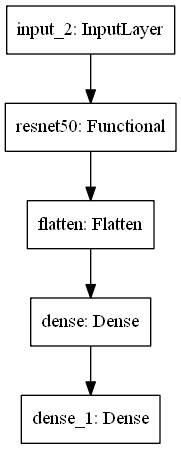

In [12]:
inputs = keras.Input(shape=(image_size, image_size, 3))
x = conv_base(inputs)
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
outputs = layers.Dense(len(filter),  activation="sigmoid")(x) 
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()
tf.keras.utils.plot_model(model)

We tune the hyperparameters of the model by Bayesian optimization, as described in section 13.1 of the textbook. The homework asked to optimize a learning schedule via call-back, but this is hard to combine with the keras tuning library, thus instead I used the learning decay keyword. The number of hidden layer units, the number of hidden layers, learning rate and learning decay rate are hyper-parameters we fine-tune. A call-back, based on stagnation of the validation loss, is used for early stopping to speed up the tuning.

In [14]:
def build_model(hp):
    num_dense_layers = hp.Int(name="num_dense_layers", min_value=0, max_value=2, step=1)
    num_hidden_units = hp.Int(name="num_hidden_units", min_value=32, max_value=512, step=32)
    learning_rate = hp.Float("lr", min_value=1e-7, max_value=1e-4, sampling="log")
    learning_decay = hp.Float("decay", min_value=1e-8, max_value=1e-5, sampling="log")
    inputs = keras.Input(shape=(image_size, image_size, 3))
    x = conv_base(inputs)
    x = layers.Flatten()(x)
    for i in range(num_dense_layers):
        x = layers.Dense(num_hidden_units, activation="relu")(x)
    outputs = layers.Dense(len(filter),  activation="sigmoid")(x) 
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=learning_rate,decay=learning_decay),
                  loss=diceloss,
                  metrics=["BinaryAccuracy","TruePositives","FalseNegatives"])
    return model

In [15]:
tuner = kt.BayesianOptimization(
    build_model,
    objective="val_loss",
    max_trials=25,
    executions_per_trial=1,
    directory="BO",
    overwrite=False,
)
tuner.search_space_summary()

INFO:tensorflow:Reloading Oracle from existing project BO\untitled_project\oracle.json
INFO:tensorflow:Reloading Tuner from BO\untitled_project\tuner0.json
Search space summary
Default search space size: 4
num_dense_layers (Int)
{'default': None, 'conditions': [], 'min_value': 0, 'max_value': 2, 'step': 1, 'sampling': None}
num_hidden_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
lr (Float)
{'default': 1e-07, 'conditions': [], 'min_value': 1e-07, 'max_value': 0.0001, 'step': None, 'sampling': 'log'}
decay (Float)
{'default': 1e-08, 'conditions': [], 'min_value': 1e-08, 'max_value': 1e-05, 'step': None, 'sampling': 'log'}


In [16]:
callbacks = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=4)]
tuner.search(ds_train_pp,epochs=50,validation_data=ds_val_pp,callbacks=callbacks,verbose=2)

INFO:tensorflow:Oracle triggered exit


We see that one hidden layer is optimal, compared to zero or two hidden layers, this hidden layer has the maximum allowed number of units. The optimal learning rate is slow, with a medium decay rate, which is not surprising since we are fine tuning a pretrained model. In the output, the epoch the call-back was triggered, is sadly not included, but through manually monitoring this, I noticed the model did not exit early. We now retrain this model structure on both the train and validation set for a slightly longer period of 60 epochs.

In [30]:
ds_full_train_pp = ds_train_pp.concatenate(ds_val_pp)
best_hps = tuner.get_best_hyperparameters(1)
final_model_structure =  build_model(best_hps[0])
final_model_structure.summary()
tuner.results_summary(1)

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
flatten_7 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               16777728  
_________________________________________________________________
dense_10 (Dense)             (None, 20)                10260     
Total params: 40,375,700
Trainable params: 40,322,580
Non-trainable params: 53,120
_________________________________________________________________
Results summary
Results in BO\untitled_project
Showing 1 best trials
Objective(name='val_loss', direction='m

In [31]:
history = final_model_structure.fit(ds_full_train_pp , epochs=60)

Epoch 1/60
326/326 [==============================] - 43s 113ms/step - loss: 0.8371 - binary_accuracy: 0.4770 - true_positives: 10907.0000 - false_negatives: 5058.0000
Epoch 2/60
326/326 [==============================] - 38s 116ms/step - loss: 0.8272 - binary_accuracy: 0.5108 - true_positives: 11137.0000 - false_negatives: 4828.0000
Epoch 3/60
326/326 [==============================] - 37s 112ms/step - loss: 0.8170 - binary_accuracy: 0.5481 - true_positives: 11202.0000 - false_negatives: 4763.0000
Epoch 4/60
326/326 [==============================] - 36s 111ms/step - loss: 0.8061 - binary_accuracy: 0.5883 - true_positives: 11158.0000 - false_negatives: 4807.0000
Epoch 5/60
326/326 [==============================] - 37s 112ms/step - loss: 0.7943 - binary_accuracy: 0.6282 - true_positives: 11083.0000 - false_negatives: 4882.0000
Epoch 6/60
326/326 [==============================] - 37s 113ms/step - loss: 0.7815 - binary_accuracy: 0.6686 - true_positives: 10944.0000 - false_negatives: 50

The homework also asks us to look at depth separable convolutions. We finetune the Xception network, with the same workflow as ResNet. For the sake of brevity, I do not include all intermediate output. We conclude that both architectures roughly perform the same.

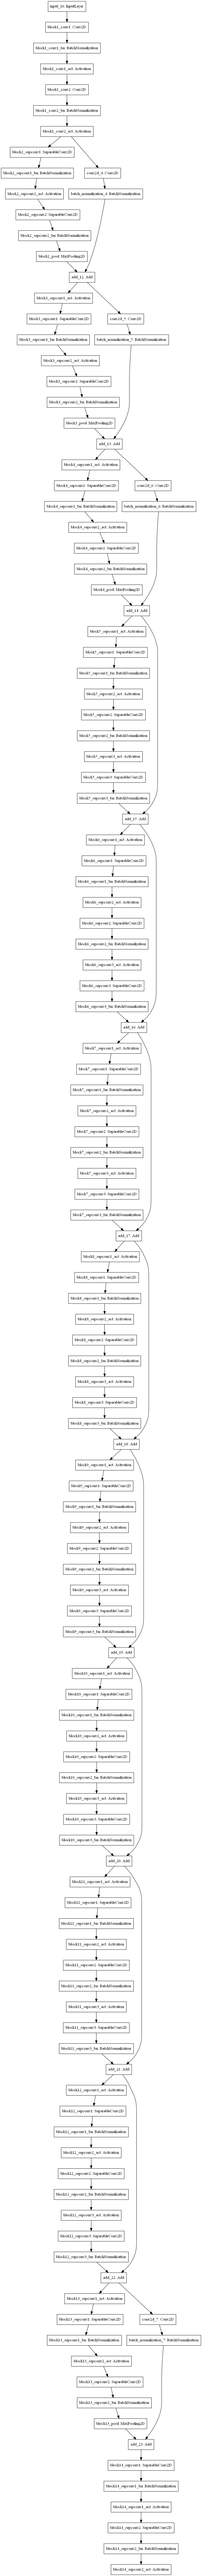

In [76]:
conv_base2 = tf.keras.applications.xception.Xception(
    include_top=False,
    input_tensor=None,
    input_shape=(image_size, image_size, 3),
)
conv_base2.trainable = True
tf.keras.utils.plot_model(conv_base2)

In [24]:
def build_model2(hp):
    num_dense_layers = hp.Int(name="num_dense_layers", min_value=0, max_value=2, step=1)
    num_hidden_units = hp.Int(name="num_hidden_units", min_value=32, max_value=512, step=32)
    learning_rate = hp.Float("lr", min_value=1e-7, max_value=1e-4, sampling="log")
    learning_decay = hp.Float("decay", min_value=1e-8, max_value=1e-5, sampling="log")
    inputs = keras.Input(shape=(image_size, image_size, 3))
    x = conv_base2(inputs)
    x = layers.Flatten()(x)
    for i in range(num_dense_layers):
        x = layers.Dense(num_hidden_units, activation="relu")(x)
    outputs = layers.Dense(len(filter),  activation="sigmoid")(x) 
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=learning_rate,decay=learning_decay),
                  loss=diceloss,
                  metrics=["BinaryAccuracy","TruePositives","FalseNegatives"])
    return model

In [25]:
tuner2 = kt.BayesianOptimization(
    build_model2,
    objective="val_loss",
    max_trials=25,
    executions_per_trial=1,
    directory="BO2",
    overwrite=False,
)

INFO:tensorflow:Reloading Oracle from existing project BO2\untitled_project\oracle.json
INFO:tensorflow:Reloading Tuner from BO2\untitled_project\tuner0.json


In [26]:
callbacks = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=4)]
tuner2.search(ds_train_pp,epochs=50, validation_data=ds_val_pp,callbacks=callbacks,verbose=2)

INFO:tensorflow:Oracle triggered exit


In [28]:
best_hps2 = tuner2.get_best_hyperparameters(1)
final_model_structure2 =  build_model2(best_hps2[0])
history = final_model_structure2.fit(ds_full_train_pp , epochs=60)

Epoch 1/60
326/326 [==============================] - 45s 121ms/step - loss: 0.8504 - binary_accuracy: 0.5661 - true_positives: 9806.0000 - false_negatives: 6159.0000
Epoch 2/60
326/326 [==============================] - 39s 121ms/step - loss: 0.8284 - binary_accuracy: 0.6837 - true_positives: 9883.0000 - false_negatives: 6082.0000
Epoch 3/60
326/326 [==============================] - 40s 121ms/step - loss: 0.8080 - binary_accuracy: 0.7528 - true_positives: 9437.0000 - false_negatives: 6528.0000
Epoch 4/60
326/326 [==============================] - 40s 122ms/step - loss: 0.7892 - binary_accuracy: 0.7928 - true_positives: 8987.0000 - false_negatives: 6978.0000
Epoch 5/60
326/326 [==============================] - 40s 122ms/step - loss: 0.7713 - binary_accuracy: 0.8230 - true_positives: 8595.0000 - false_negatives: 7370.0000
Epoch 6/60
326/326 [==============================] - 39s 121ms/step - loss: 0.7536 - binary_accuracy: 0.8485 - true_positives: 8256.0000 - false_negatives: 7709.000

Even though both networks perform similarly, it might be that a combination of the models performs better than the performance of an individual model. This is because perhaps one model is somewhat blind to detecting the presence of certain labels, while the other model might be better at detecting those labels. Vice-versa the first model might perform well on certain labels, which the second model does not detect. We perform classification on the test data by averaging the predictions of the two fine-tuned model structures. We could also use a weighted average, and optimize this hyperparameter, but we keep the weights fixed at 0.5 for simplicity.

In [36]:
models = [final_model_structure, final_model_structure2]
model_input = tf.keras.Input(shape=(image_size, image_size, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = tf.keras.layers.Average()(model_outputs)
ensemble_model = tf.keras.Model(inputs=model_input, outputs=ensemble_output)
ensemble_model.compile(loss=diceloss, metrics=["BinaryAccuracy","TruePositives","FalseNegatives"])
ensemble_model.evaluate(ds_test_pp)

37/37 [==============================] - 3s 34ms/step - loss: 0.4487 - binary_accuracy: 0.9477 - true_positives: 923.0000 - false_negatives: 831.0000


[0.4486938714981079, 0.9476602077484131, 923.0, 831.0]

In [ ]:
y_pred = np.array(ensemble_model.predict(ds_test_pp) > 0.5, dtype=np.int32)
y_true = np.array(y_test, dtype=np.int32)
metric = tfa.metrics.MultiLabelConfusionMatrix(num_classes=len(filter))
metric.update_state(y_true, y_pred)
# TN FP
# FN TP
for i in range(len(filter)):
    print(filter[i])
    print(result[i])

The accuracy on the test set is not impressive at first glance. Let us look at some of the images in the test set to see the model in action. 

Most of the obvious images such as row 5 columns 2-3 are labelled correctly.

Generally, if there is an object front and centre in an image it is correctly labelled, but if the image also contains other objects in the background, the model has difficulty detecting these. This is understandable, it is difficult to see the potted plant in row 4 column 2, the car in row 4 column 4, and the chair in row 1 column 4.

I also find it understandable the model adds the chair label to row 1 column 3, and if row 3 column 4 is a dining table than row 2 column 3 is also one. The addition of the person label to row 2 column 3 is a funny mistake.

The model adds the label person too often. This is due to the imbalance between the different labels in the dataset, weighing down the human class in the loss can remedy this.

More surprising to me, is the inability of the model to label horses correctly. 

In conclusion, multi-label classification is much harder than single-label classification in the best of situations, as potentially all labels, a single label or anything in between could be present in the image. Combine this with images that are not very easy to label even for humans, and the performance of our model can still be considered acceptable.

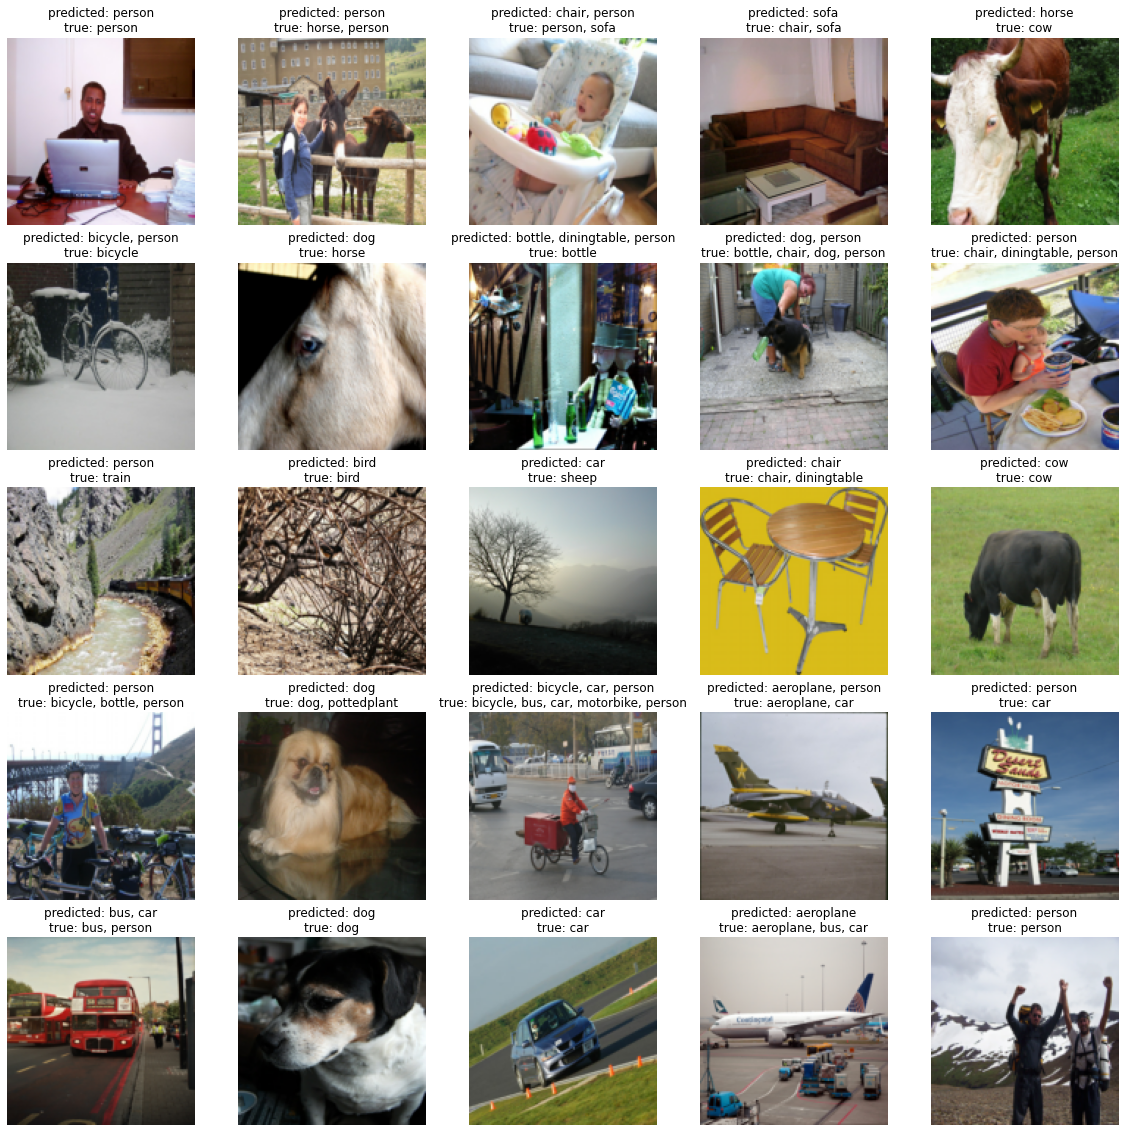

In [64]:
num_pics = 25
x,y = iter(ds_test_no_pp).next()
pred = ensemble_model.predict(keras.applications.resnet50.preprocess_input(x))[0:num_pics] > 0.5
plt.figure(figsize=(20,20))
for i in range(num_pics):
    ax=plt.subplot(5,5,i+1)
    ax.imshow(x[i].numpy().astype('uint8'))
    predicted_labels = []
    for j in range(len(filter)):
        if pred[i][j]:
            predicted_labels.append(filter[j])
    ax.set_title("predicted: " + ', '.join(predicted_labels) + "\n" + "true: " + ', '.join(indices_to_names(y[i],filter)))
    ax.axis('off')
plt.show()